The Ornstein–Uhlenbeck process is a type of stochastic process that can be used to model the volatility of a stock or index price. It assumes that the volatility has a mean-reverting behavior, meaning that it tends to return to a long-term average level over time. Some studies have extended this model by adding features such as stochastic volatility or infinite jumps to capture more realistic aspects of the market dynamics.

In [15]:
import yfinance as yf
import time
import math
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(16,6)
plt.style.use('dark_background')
from pandas_datareader import data as pdr
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf

In [16]:
# import data
def get_data(stock_index, start, end):
    df = yf.download(stock_index, start, end)
    return df
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=1260)
stock_index_prices = get_data('^DJI', startDate, endDate)
print(startDate)
stock_index_prices.head()

[*********************100%***********************]  1 of 1 completed
2020-03-29 16:15:36.115065


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-30,21678.220703,22378.089844,21522.080078,22327.480469,22327.480469,545540000
2020-03-31,22208.419922,22480.369141,21852.080078,21917.160156,21917.160156,571210000
2020-04-01,21227.380859,21487.240234,20784.429688,20943.509766,20943.509766,506680000
2020-04-02,20819.460938,21477.769531,20735.019531,21413.439453,21413.439453,529540000
2020-04-03,21285.929688,21447.810547,20863.089844,21052.529297,21052.529297,450010000


In [17]:
stock_index_prices.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-01,34876.238281,34979.179688,34720.699219,34837.710938,34837.710938,286370000
2023-09-05,34843.218750,34871.261719,34635.628906,34641.968750,34641.968750,283540000
2023-09-06,34611.679688,34611.679688,34291.558594,34443.191406,34443.191406,308900000
2023-09-07,34351.179688,34560.859375,34351.179688,34500.730469,34500.730469,386980000
2023-09-08,34487.410156,34627.851562,34473.570312,34576.589844,34576.589844,293990000


Volatility clustering in financial time series

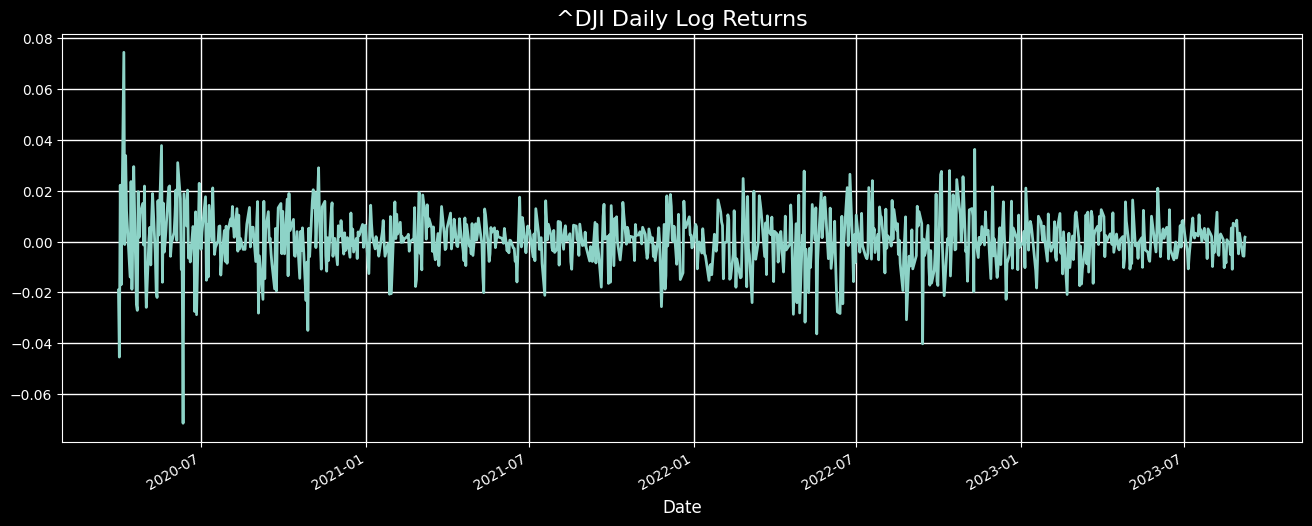

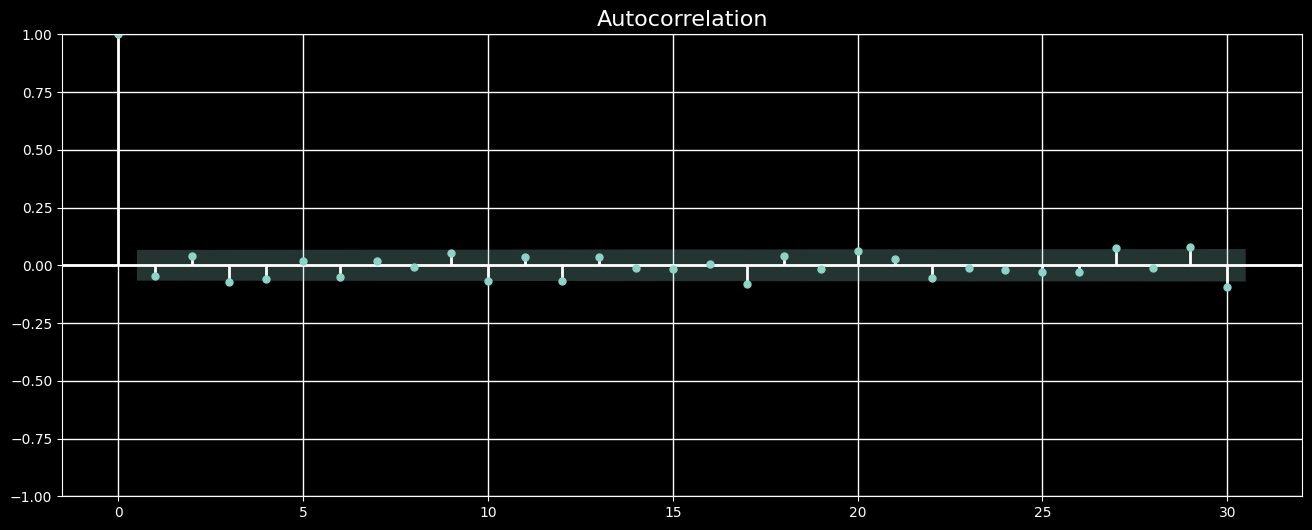

In [18]:
log_returns = np.log(stock_index_prices.Close/stock_index_prices.Close.shift(1)).dropna()
log_returns.plot()
plt.title('^DJI Daily Log Returns')
plot_acf(log_returns)
plt.show()

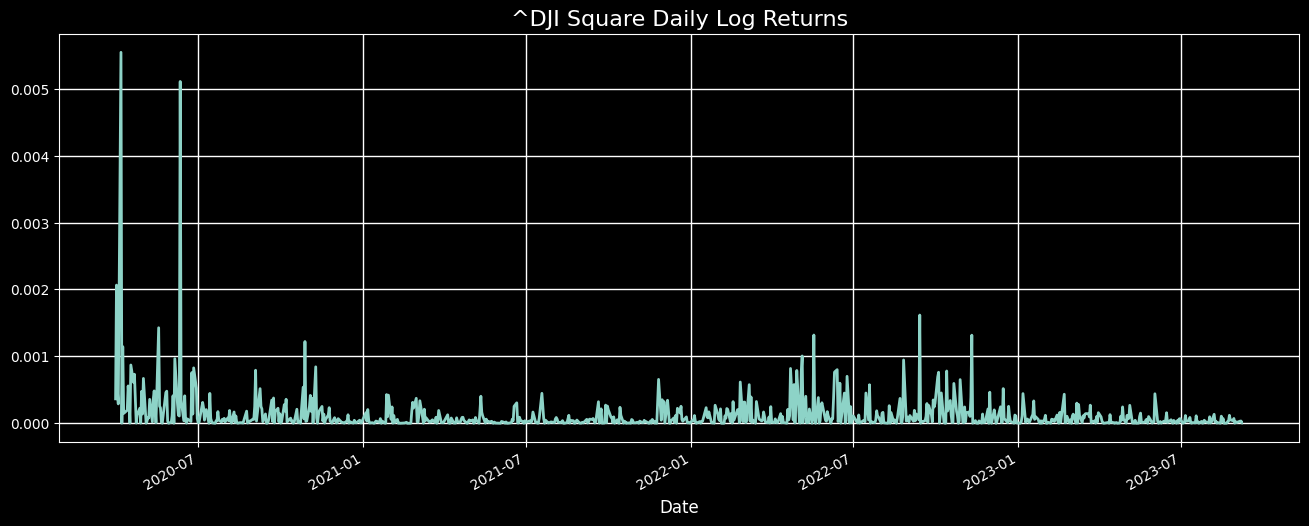

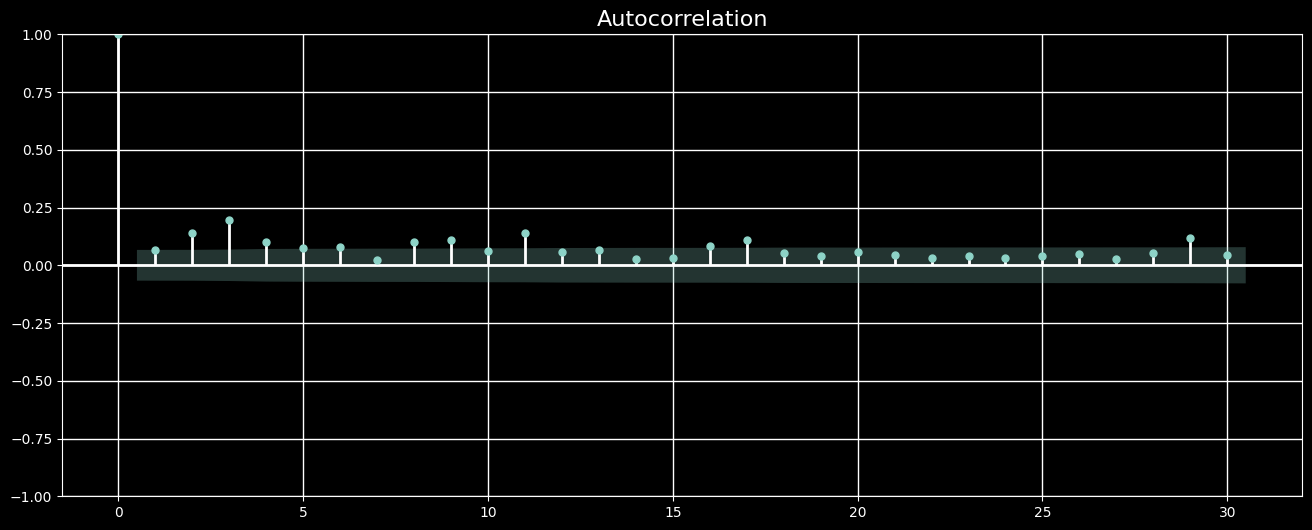

In [19]:
log_returns_sq = np.square(log_returns)
log_returns_sq.plot()
plt.title('^DJI Square Daily Log Returns')
plot_acf(log_returns_sq)
plt.show()

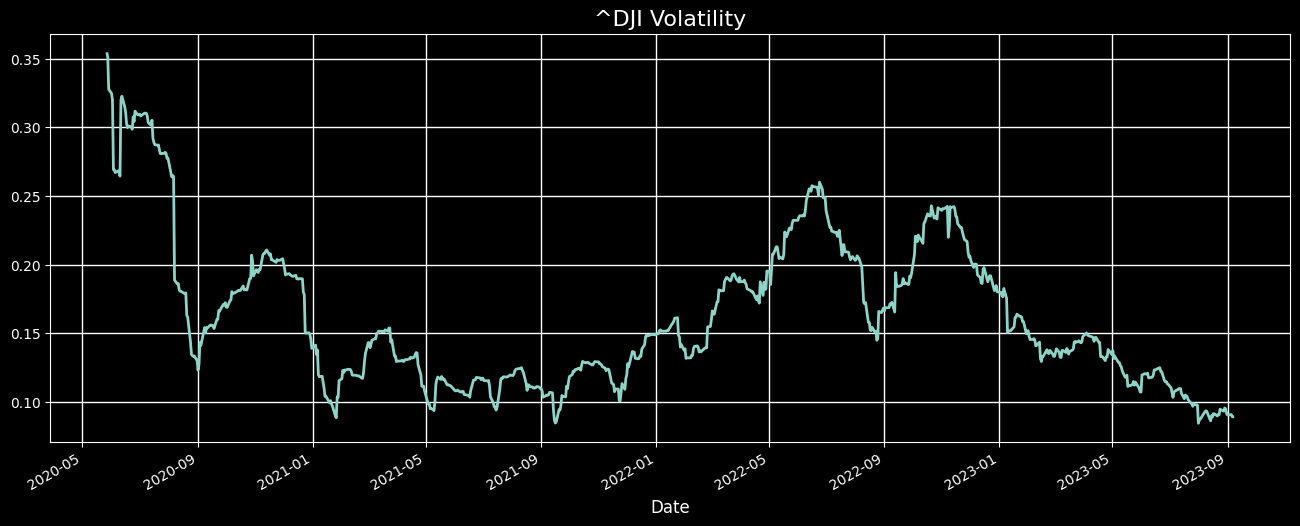

In [20]:
TRADING_DAYS = 40
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)
volatility = volatility.dropna()
volatility.plot()
plt.title('^DJI Volatility')
plt.show()

Ornstein-Uhlenbeck

In [21]:
def MLE_norm(x):
    mu_hat = np.mean(x)
    sigma2_hat = np.var(x)
    return mu_hat, sigma2_hat
mu = 5
sigma = 2.5
N = 10000
np.random.seed(0)
x = np.random.normal(loc=mu, scale=sigma, size=(N,))
mu_hat, sigma2_hat = MLE_norm(x)
for_mu_hat = '$\hat{\mu} = '+format(round(mu_hat,2))+'$'
for_sigma2_hat = '$\hat{\sigma} = '+format(round(np.sqrt(sigma2_hat),2))+'$'
print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Performing MLE numerically

In [22]:
def log_likelihood(theta, x):
    mu = theta[0]
    sigma = theta[1]
    
    l_theta = np.sum( np.log( sc.stats.norm.pdf(x, loc=mu, scale=sigma) ) )
    
    return -l_theta
def sigma_pos(theta):
    sigma = theta[1]
    return sigma
cons_set = {'type':'ineq', 'fun': sigma_pos}
theta0 = [2,3]
opt = sc.optimize.minimize(fun=log_likelihood, x0=theta0, args=(x,), constraints=cons_set)
for_mu_hat = '$\hat{\mu} = '+format(round(opt.x[0],2))+'$'
for_sigma2_hat = '$\hat{\sigma} = '+format(round(opt.x[1],2))+'$'
print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


C:\Users\aaron\AppData\Local\Temp\ipykernel_14128\2992192522.py:5: RuntimeWarning: divide by zero encountered in log
  l_theta = np.sum( np.log( sc.stats.norm.pdf(x, loc=mu, scale=sigma) ) )


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

MLE of Ornstein-Uhlenbeck process

In [23]:
def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)
def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))
def log_likelihood_OU(theta_hat, x):
    kappa = theta_hat[0]
    theta = theta_hat[1]
    sigma = theta_hat[2]
    
    x_dt = x[1:]
    x_t = x[:-1]
    
    dt = 1/252
    
    mu_OU = mu(x_t, dt, kappa, theta)
    sigma_OU = std(dt, kappa, sigma)
    
    l_theta_hat = np.sum( np.log( sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU) ) )
    
    return -l_theta_hat
def kappa_pos(theta_hat):
    kappa = theta_hat[0]
    return kappa
def sigma_pos(theta_hat):
    sigma = theta_hat[2]
    return sigma
vol = np.array(volatility)
cons_set = [{'type':'ineq', 'fun': kappa_pos},
            {'type':'ineq', 'fun': sigma_pos}]
theta0 = [1,3,1]
opt = sc.optimize.minimize(fun=log_likelihood_OU, x0=theta0, args=(vol,), constraints=cons_set)
kappa = round(opt.x[0],3)
theta = round(opt.x[1],3)
sigma = round(opt.x[2],3)
vol0 = vol[-1]
for_kappa_hat = '$\hat{\kappa} = '+str(kappa)+'$'
for_theta_hat = '$\hat{\Theta} = '+str(theta)+'$'
for_sigma_hat = '$\hat{\sigma} = '+str(sigma)+'$'
print('The MLE for data is:')
display(Latex(for_kappa_hat))
display(Latex(for_theta_hat))
display(Latex(for_sigma_hat))
print('Last Volatility', round(vol0,3))

The MLE for data is:


C:\Users\aaron\AppData\Local\Temp\ipykernel_14128\98068347.py:20: RuntimeWarning: divide by zero encountered in log
  l_theta_hat = np.sum( np.log( sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU) ) )


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Last Volatility 0.089


Simulating Ornstein-Uhlenbeck process

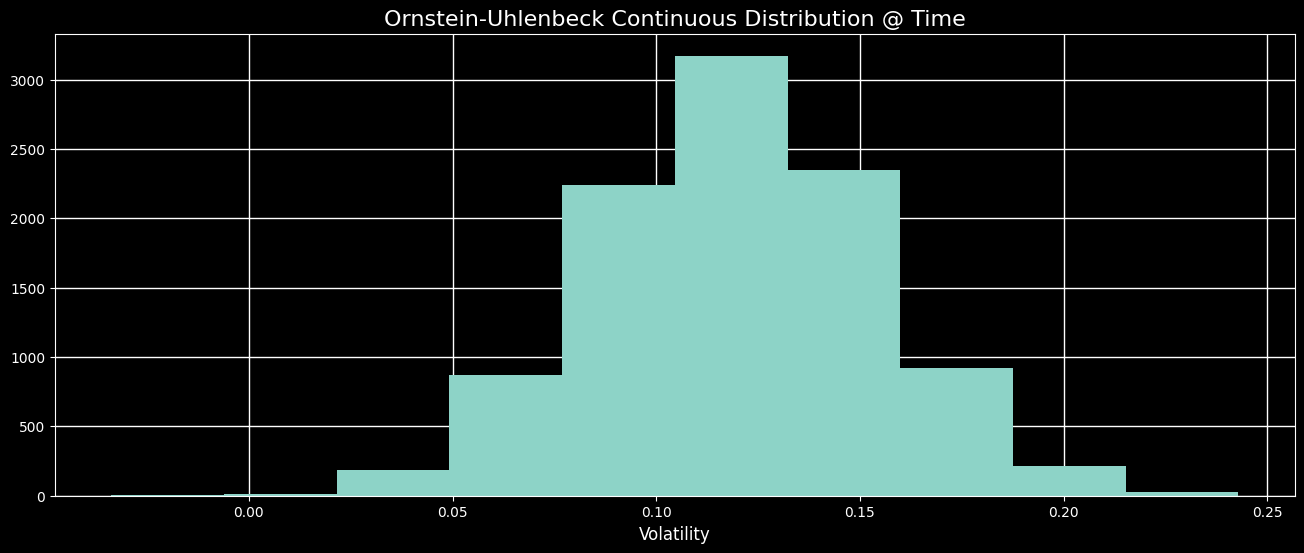

In [24]:
# define parameters
Time = 0.3
M = 10000
Z = np.random.normal(size=(M))
def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)
def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))
drift_OU = mu(vol0, Time, kappa, theta)
diffusion_OU = std(Time, kappa, sigma)
vol_OU = drift_OU + diffusion_OU*Z
plt.hist(vol_OU)
plt.title('Ornstein-Uhlenbeck Continuous Distribution @ Time')
plt.xlabel('Volatility')
plt.show()

Discretised SDE 

In [25]:
# Initialise Parameters for discretization
days = 1
years = 2
dt = days/252
M = 1000
N = int(years/dt)

Recursive Function

Execution time 0.009012222290039062


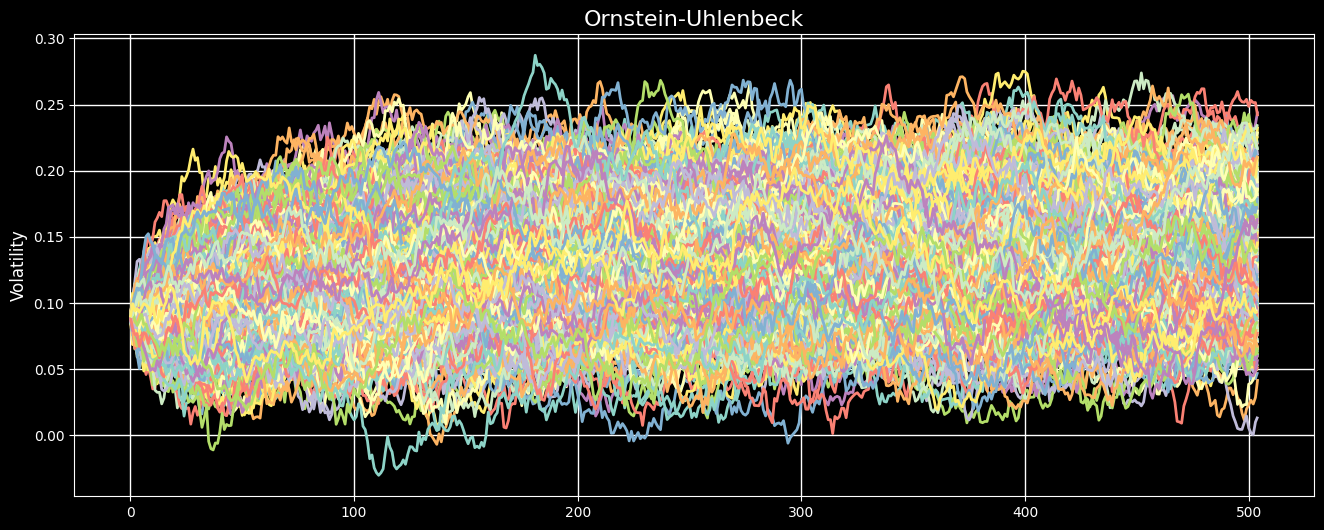

In [26]:
vol_OU = np.full(shape=(N, M), fill_value=vol0)
Z = np.random.normal(size=(N, M))
def OU_recursive(t, vol_OU):
    # Return the final state
    if t == N:
        return vol_OU
    
    # Thread the state through the recursive call
    else:
        drift_OU = kappa*(theta - vol_OU[t-1])*dt
        diffusion_OU = sigma*np.sqrt(dt)
        vol_OU[t] = vol_OU[t-1] + drift_OU + diffusion_OU*Z[t]
        return OU_recursive(t + 1, vol_OU)
    
    
start_time = time.time() 
vol_OU = OU_recursive(0, vol_OU)
print('Execution time', time.time() - start_time)
vol_OU = np.concatenate( (np.full(shape=(1, M), fill_value=vol0), vol_OU ) )
plt.plot(vol_OU)
plt.title('Ornstein-Uhlenbeck')
plt.ylabel('Volatility')
plt.show()

Python Loop

Execution time 0.012377262115478516


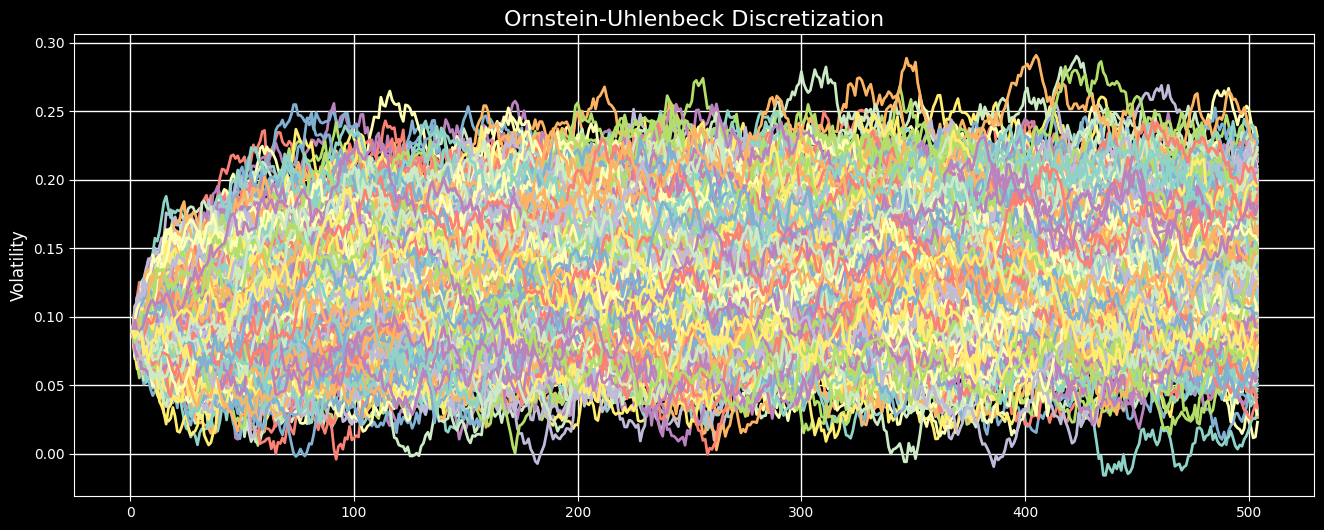

In [27]:
vol_OU = np.full(shape=(N, M), fill_value=vol0)
Z = np.random.normal(size=(N, M))
start_time = time.time()
for t in range(1,N):
    drift_OU = kappa*(theta - vol_OU[t-1])*dt
    diffusion_OU = sigma*np.sqrt(dt)
    vol_OU[t] = vol_OU[t-1] + drift_OU + diffusion_OU*Z[t]
print('Execution time', time.time() - start_time)
vol_OU = np.concatenate( (np.full(shape=(1, M), fill_value=vol0), vol_OU ) )
plt.plot(vol_OU)
plt.title('Ornstein-Uhlenbeck Discretization')
plt.ylabel('Volatility')
plt.show()